# Prueba Final

### Integrantes
<small>

 - Francisca Pinto
 - Francisco Silva
 - Paula Rivera
 - Verónica Martínez
 - Benjamín Meneses
</small>

## Descripción Del Problema

## Preparación del ambiente de Trabajo

In [1]:
#tiempo de ejecución
%load_ext autotime

#dataframe y arrays
import pandas as pd
import numpy as np

#estadística
import scipy.stats as stats

#gráficos
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#gama matplotlib para facilitar escritura de código
%matplotlib inline

#separación entrenamiento validación
from sklearn.model_selection import train_test_split, GridSearchCV

#pipeline
from sklearn.pipeline import Pipeline

#Árbol de decisión de regresión
from sklearn.tree import DecisionTreeClassifier

#AdaBoost Clasiffier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

#dataframe filter
import re

#AUX: montar archivos y carpetas desde Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error


from darts.metrics import rho_risk
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics.metrics import mape, mae, r2_score
from darts import concatenate

time: 9.23 s (started: 2022-03-06 00:33:45 -03:00)


In [2]:
from darts.models import ExponentialSmoothing, NBEATSModel
from darts.models.forecasting.arima import ARIMA

time: 4.55 s (started: 2022-03-06 00:33:55 -03:00)


In [3]:
# Importamos los datos
path_items = 'items.csv'
path_sales = 'ventas.csv'
path_salesperson = 'vendedores.csv'
path_extra = 'temperatura.csv'

df_items = pd.read_csv(path_items)
df_sales = pd.read_csv(path_sales)
df_salesperson = pd.read_csv(path_salesperson)
df_temperature = pd.read_csv(path_extra)

random_seed = 3748

time: 32 ms (started: 2022-03-06 00:33:59 -03:00)


### Recodificación de columnas

Haremos un análisis de las columnas y pasaremos a refactorizar los nombres

In [4]:
# Vemos las columnas actuales
print('Productos')
print(df_items.columns)
print('Ventas')
print(df_sales.columns)
print('Vendedores')
print(df_salesperson.columns)

Productos
Index(['Familia', 'Peso ( Kg )', 'InventoryUoMName',
       'InventoryValuationMethod_E', 'Es artículo de Inventario',
       'Es artículo de compras', 'Es artículo de ventas', 'ItemCode',
       'ItemDescriptionAndCode', 'Descripción del artículo', 'ItemGroupName',
       'El articulo esta activo', 'Sub - Familia'],
      dtype='object')
Ventas
Index(['Cantidad (en UM de inventario)', 'VentaNeta', 'CodCliente',
       'Número de documento', 'ItemCode', 'CodVendedor',
       'Código de almacén de línea', 'Fecha', 'Descripción del artículo',
       'CanalDeVenta', 'Kilombos'],
      dtype='object')
Vendedores
Index(['Active', 'Locked', 'Codigo Vendedor', 'Nombre Vendedor'], dtype='object')
time: 0 ns (started: 2022-03-06 00:33:59 -03:00)


No se borrarán de <code>Items</code> inmediato las columnas <code>Peso (kg)</code> y <code>El articulo esta activo</code> ya que:
- El peso se utilizará para sumar las filas para agrupar las ventas
- La categoría del artículo se usará para filtrar la tabla <code>Items</code>

In [5]:
df_items.drop(columns = ["Familia",
                         "InventoryUoMName",
                         "InventoryValuationMethod_E",
                         "Es artículo de Inventario",
                         "Es artículo de compras",
                         "Es artículo de ventas",
                         "ItemDescriptionAndCode",
                         "ItemGroupName",
                         "Sub - Familia"],
              inplace = True)

df_sales.drop(columns = ["Cantidad (en UM de inventario)",
                         "Código de almacén de línea",
                         "ItemCode",
                         "CanalDeVenta"],
              inplace = True)

df_salesperson.drop(columns = ["Active",
                               "Locked",
                               "Nombre Vendedor"],
                    inplace = True)

time: 0 ns (started: 2022-03-06 00:33:59 -03:00)


In [6]:
# Vemos las columnas refactorizadas
print('Productos')
print(df_items.columns)
print('Ventas')
print(df_sales.columns)
print('Vendedores')
print(df_salesperson.columns)

Productos
Index(['Peso ( Kg )', 'ItemCode', 'Descripción del artículo',
       'El articulo esta activo'],
      dtype='object')
Ventas
Index(['VentaNeta', 'CodCliente', 'Número de documento', 'CodVendedor',
       'Fecha', 'Descripción del artículo', 'Kilombos'],
      dtype='object')
Vendedores
Index(['Codigo Vendedor'], dtype='object')
time: 0 ns (started: 2022-03-06 00:34:00 -03:00)


Luego analizaremos los productos activos filtrando la tabla <code>Items</code> por la categoría <code>El articulo esta activo</code> con etiqueta positiva, <code>Y</code>.

In [7]:
# Filtramos los productos y nos quedamos sólo con los activos
df_items = df_items[df_items['El articulo esta activo'] == 'Y']
df_items.drop(columns = ['El articulo esta activo'],inplace = True)

time: 0 ns (started: 2022-03-06 00:34:00 -03:00)


In [8]:
# Vemos como quedó el df
df_items

,Peso ( Kg ),ItemCode,Descripción del artículo
0,0.2,100402405101,Almendra Cubierta Con Chocolate De Leche Bl 20...
1,0.2,140201405101,Cranberry Entero Cubierta Chocolate Bitter Bl...
2,0.2,140202405101,Cranberry Cubierta Chocolate Leche Bl. 200 Gr.
4,1.0,100402409101,Almendras Cubiertas Con Chocolate De Leche Bl ...
8,1.0,140201409102,Cranberry Entero Cubierta Chocolate Bitter Bl...
9,1.0,140202408102,Cranberry Cubierta Chocolate Leche Bl. 1Kg
10,1.0,140202409101,Cranberry Cubierta Chocolate Leche Bl. 5Kg
11,1.0,140203409101,Cranberry Cubierta Chocolate Blanco Bl. 5Kg
12,0.2,100401405101,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.
13,0.2,260501405101,Mani Cubierta Chocolate Bitter Bl. 200Gr.


time: 15 ms (started: 2022-03-06 00:34:00 -03:00)


Continuamos con el renombramiento final de las columnas de cada dataframe

In [9]:
def refactor(cols, df):
    newDf = df.copy()
    newDf.rename(columns = cols, inplace = True)
    return newDf

df_sales = refactor({
    'VentaNeta' : 'venta_neta',
    'CodCliente' : 'cod_cliente',
    'Número de documento' : 'num_documento',
    'Descripción del artículo' : 'description',
    'CodVendedor' : 'cod_vendedor',
    'Fecha' : 'fecha',
    'Kilombos' : 'kilombos'
    }, df_sales)
df_items = refactor({
    'Peso ( Kg )' : 'peso',
    'ItemCode' : 'item_code',
    'Descripción del artículo' : 'description',
    }, df_items)
df_salesperson = refactor({'Codigo Vendedor' : 'codigo_vendedor'}, df_salesperson)
df_temperature = refactor({'Fecha' : 'fecha', 'Temperatura media Cº' : 'temperatura_media'}, df_temperature)

time: 0 ns (started: 2022-03-06 00:34:00 -03:00)


### Anonimización de Descripciones

In [10]:
# Conseguimos las descripciones unicas para ventas e listado de productos
items = np.unique(df_items['description'])
sales = np.unique(df_sales['description'])

# Vemos los productos que no están en listado de productos
registro_encontrado = []
registro_no_encontrado = []
for i in sales:
  if i in items:
    registro_encontrado.append(i)
  else:
    registro_no_encontrado.append(i)
# Imprimimos los no encontrados
print('Productos no encontrados')
print(registro_no_encontrado)

Productos no encontrados
['Almendra Cubiertas Con Chocolate Bitter Bl 1 Kg.', 'Almendras Cubiertas Con Chocolate De Leche Bl 1 Kg', 'Cranberry Entero  Cubierta Chocolate Bitter Bl. 1Kg', 'Mani Cubierta Chocolate Leche Bl. 1Kg.']
time: 0 ns (started: 2022-03-06 00:34:00 -03:00)


Notamos que hay Items que no están en el listado de productos

Por lo mis, la tabla <code>Items</code> no contiene la totalidad de los posibles productos a vender. Por otro lado, las descripciones de la columna <code>description</code> en la tabla <code>SalesFact</code> ya entregan la información necesaria de cada producto.

Por lo anterior, no se utilizará la tabla <code>Items</code> para continuar el procesamiento de datos, y solo se considerarán los registros de la columna <code>description</code> de <code>df_sales</code>. Se re-codificará con un diccionario.

In [11]:
df_sales

,venta_neta,cod_cliente,num_documento,cod_vendedor,fecha,description,kilombos
0,58172.0,C77196968,1054011,11,5-Apr-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,6.0
1,116345.0,C76047944,1065766,4,11-Aug-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,12.0
2,116344.0,C76047944,1071927,4,20-Oct-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,12.0
3,116345.0,T00000581,1044987,38,3-Nov-20,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,12.0
4,116345.0,T00000377,1055172,38,21-Apr-21,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.,12.0
...,...,...,...,...,...,...,...
5958,33614.0,C76856428,1073400,11,9-Nov-21,Mani Cubierta Chocolate Leche Bl. 5Kg,5.0
5959,33613.0,C76856428,1074486,11,25-Nov-21,Mani Cubierta Chocolate Leche Bl. 5Kg,5.0
5960,67227.0,C77137814,1074961,38,2-Dec-21,Mani Cubierta Chocolate Leche Bl. 5Kg,10.0
5961,33613.0,C16686358,1074945,38,2-Dec-21,Mani Cubierta Chocolate Leche Bl. 5Kg,5.0


time: 15 ms (started: 2022-03-06 00:34:00 -03:00)


In [12]:
sales_description_dict = {
    "Almendra Cubierta Con Chocolate Bitter Bl 200Gr." : "AA1", 
    "Almendra Cubierta Con Chocolate De Leche Bl 200Gr." : "AB1",
    "Almendra Cubiertas Con Chocolate Bitter Bl 1 Kg." : "AA2",
    "Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg." : "AA3",
    "Almendras Cubiertas Con Chocolate De Leche Bl 1 Kg" : "AB2",
    "Almendras Cubiertas Con Chocolate De Leche Bl 5 Kg" : "AB3",
    "Cranberry Cubierta Chocolate Leche Bl. 200 Gr." : "BB1",
    "Cranberry Cubierta Chocolate Leche Bl. 5Kg" : "BB3", #BB2 no existe pero se salta para evitar confusiones
    "Cranberry Entero  Cubierta Chocolate Bitter Bl. 1Kg" : "BA2",
    "Cranberry Entero  Cubierta Chocolate Bitter Bl. 5Kg" : "BA3",
    "Cranberry Entero  Cubierta Chocolate Bitter Bl.200 Gr." : "BA1",
    "Mani Cubierta Chocolate Bitter Bl. 200Gr." : "CA1",
    "Mani Cubierta Chocolate Bitter Bl. 5Kg" : "CA3", #CA2 no existe pero se salta para evitar confusiones
    "Mani Cubierta Chocolate Leche Bl. 1Kg." : "CB2",
    "Mani Cubierta Chocolate Leche Bl. 200Gr." : "CB1",
    "Mani Cubierta Chocolate Leche Bl. 5Kg" : "CB3"
}
# Anonimizamos
df_sales['description'] = df_sales['description'].replace(sales_description_dict)
# Agregamos el grupo al que corresponden
df_sales['grupo'] = df_sales['description'].apply(lambda x: x[0:2])
#Verificamos la anonimización
print('Productos', df_sales['description'].unique())
print('Grupos', df_sales['grupo'].unique())

Productos ['AA1' 'AB1' 'AA2' 'AA3' 'AB2' 'AB3' 'BB1' 'BB3' 'BA2' 'BA3' 'BA1' 'CA1'
 'CA3' 'CB2' 'CB1' 'CB3']
Grupos ['AA' 'AB' 'BB' 'BA' 'CA' 'CB']
time: 16 ms (started: 2022-03-06 00:34:00 -03:00)


### Recodificación de atributo temporal

In [13]:
# Refactorizamos la columna fecha
df_sales['ds'] = df_sales['fecha'].apply(lambda date: pd.to_datetime(date, format='%d-%b-%y')).sort_values(ascending=True)
df_sales['ds-monthYear'] = df_sales['ds'].dt.strftime('%Y-%m')
df_sales['ds-weekYear'] = df_sales['ds'].dt.strftime('%Y-%U')
df_sales.drop(columns = ['fecha'],
              inplace = True)

time: 1.09 s (started: 2022-03-06 00:34:00 -03:00)


### Recodificación de tipos de datos

In [14]:
df_sales.venta_neta.astype('float64')
df_sales.cod_cliente.astype('str')
df_sales.num_documento.astype('int32')
df_sales.cod_vendedor.astype('int32')
df_sales.description.astype('str')
df_sales.kilombos.astype('float64')
df_temperature.fecha = pd.to_datetime(df_temperature['fecha'], format = '%d/%m/%Y')
df_temperature.temperatura_media.astype('float64');

time: 15 ms (started: 2022-03-06 00:34:01 -03:00)


In [15]:
 # Comprobamos la asignación correcta de tipos de dato por columna
df_sales.dtypes

venta_neta              float64
cod_cliente              object
num_documento             int64
cod_vendedor              int64
description              object
kilombos                float64
grupo                    object
ds               datetime64[ns]
ds-monthYear             object
ds-weekYear              object
dtype: object

time: 0 ns (started: 2022-03-06 00:34:02 -03:00)


In [16]:
df_temperature.dtypes

fecha                datetime64[ns]
temperatura_media           float64
dtype: object

time: 0 ns (started: 2022-03-06 00:34:02 -03:00)


### Análisis de datos anómalos

#### Datos Anómalos

In [17]:
# Verificamos que quedaron anonimizadas
df_sales.groupby(['description']).size()

description
AA1     102
AA2       1
AA3    1069
AB1      83
AB2       1
AB3     733
BA1     105
BA2       1
BA3    1318
BB1      74
BB3     657
CA1      85
CA3     897
CB1      89
CB2       1
CB3     747
dtype: int64

time: 0 ns (started: 2022-03-06 00:34:02 -03:00)


In [18]:
# Eliminamos los que aparecen una vez
df_clean = df_sales[~df_sales['description'].isin(['AA2', 'AB2', 'BA2', 'CB2'])]
df_clean.groupby(['description']).size()

description
AA1     102
AA3    1069
AB1      83
AB3     733
BA1     105
BA3    1318
BB1      74
BB3     657
CA1      85
CA3     897
CB1      89
CB3     747
dtype: int64

time: 0 ns (started: 2022-03-06 00:34:02 -03:00)


#### Anulaciones

In [19]:
# Definición de anulaciones: kilos de transacción menores a 0
df_sales_cancelled = df_clean[df_clean['kilombos'] < 0]
print('Anulaciones', '\nCantidad de anulaciones:', df_sales_cancelled.shape[0], '\nCantidad de num_documento de anulaciones (operaciones por comprador): ', len(np.unique(df_sales_cancelled['num_documento'])))
print(df_sales_cancelled['kilombos'].describe())
print(df_sales_cancelled['kilombos'].sum())
df_clean[df_clean['kilombos'] > 0]['kilombos'].sum()

Anulaciones 
Cantidad de anulaciones: 89 
Cantidad de num_documento de anulaciones (operaciones por comprador):  47
count     89.000000
mean     -11.400000
std       18.228599
min     -100.000000
25%      -10.000000
50%       -5.000000
75%       -5.000000
max       -0.200000
Name: kilombos, dtype: float64
-1014.5999999999999


55657.4

time: 15 ms (started: 2022-03-06 00:34:02 -03:00)


Notamos que hay 89 registros de devolución, repartidas en 47 documentos distintos. Creemos entonces que lo mejor es dejar estos datos 

#### Outliers

In [20]:
df_clean.columns

Index(['venta_neta', 'cod_cliente', 'num_documento', 'cod_vendedor',
       'description', 'kilombos', 'grupo', 'ds', 'ds-monthYear',
       'ds-weekYear'],
      dtype='object')

time: 0 ns (started: 2022-03-06 00:34:02 -03:00)


In [21]:
# Identificamos la media y desviacion estandar por semana
df_sales_weekly = df_clean.groupby(['ds-weekYear', 'grupo']).agg({'kilombos' : ['mean', 'std']})
df_sales_weekly.columns = ['mean', 'std']
df_sales_weekly.reset_index(inplace = True)
# Creamos un hash para identificar las semanas
weeks = {}
for i, series in df_sales_weekly.iterrows():
    if(series['ds-weekYear'] not in weeks.keys()):
        weeks[series['ds-weekYear']] = {}
    weeks[series['ds-weekYear']][series['grupo']] = {
        'mean' : series['mean'],
        'std' : series['std']
    }
def checkOutlier(x, mean, std, steps):
    if(x > mean + steps * std or x < mean - steps * std):
        return 1
    else:
        return 0
# Marcamos los valores que no cumplen con la media y desviacion estandar
for i, row in df_clean.iterrows():
    mean = weeks[row['ds-weekYear']][row['grupo']]['mean']
    std = weeks[row['ds-weekYear']][row['grupo']]['std']
    if row['ds-weekYear'] in weeks:
        df_clean.at[i, 'outlier-1'] = checkOutlier(row['kilombos'], mean, std, 1)
        df_clean.at[i, 'outlier-2'] = checkOutlier(row['kilombos'], mean, std, 2)
        df_clean.at[i, 'outlier-3'] = checkOutlier(row['kilombos'], mean, std, 3)
        df_clean.at[i, 'outlier-1-5'] = checkOutlier(row['kilombos'], mean, std, 1.5)
    else:
        print('Semana no encontrada', row['ds-weekYear'], row['grupo'])
        df_clean.at[i, 'outlier-1'] = 1
        df_clean.at[i, 'outlier-2'] = 1
        df_clean.at[i, 'outlier-3'] = 1
        df_clean.at[i, 'outlier-1-5'] = 1


time: 1.67 s (started: 2022-03-06 00:34:02 -03:00)


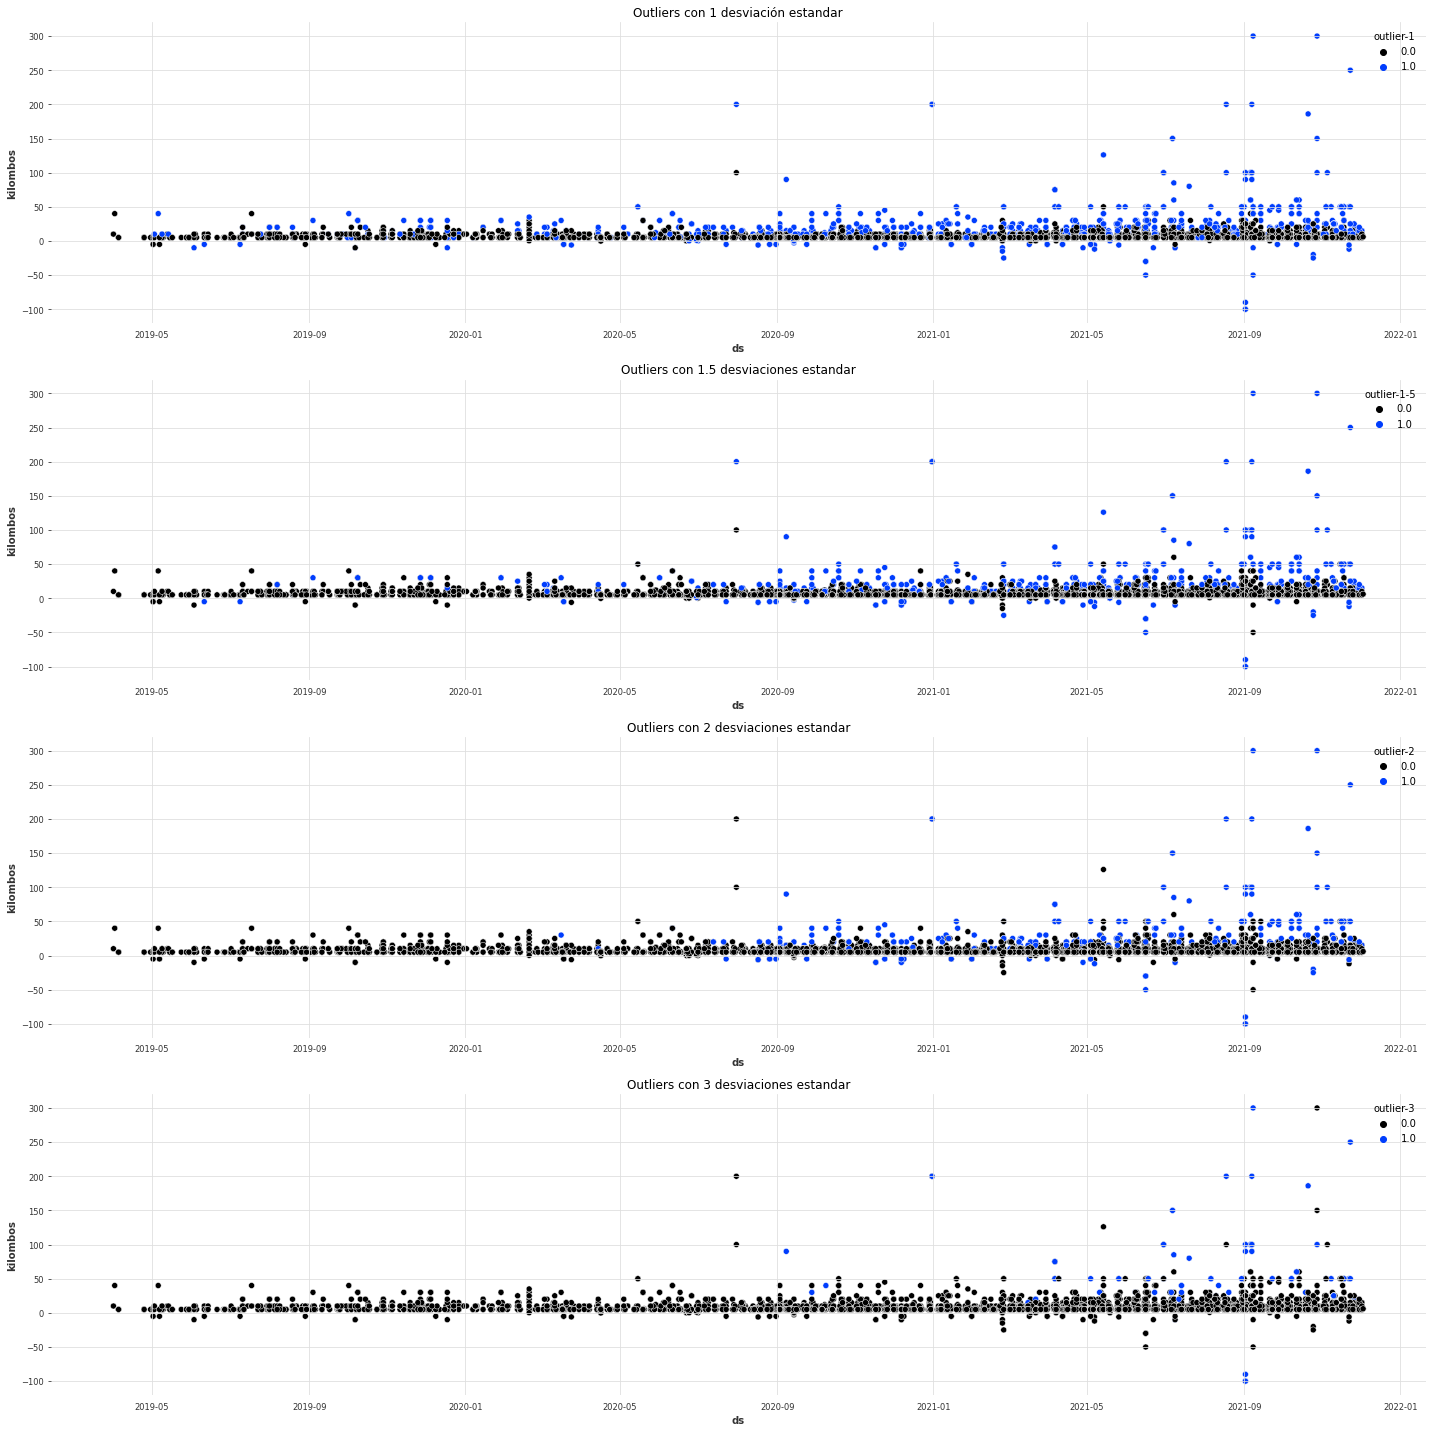

time: 2.92 s (started: 2022-03-06 00:34:04 -03:00)


In [22]:
# Graficamos los outliers en la serie de kilos
fig, ax = plt.subplots(4, 1,figsize=(20,20))
sns.scatterplot(df_clean['ds'], df_clean['kilombos'], hue = df_clean['outlier-1'], ax=ax[0])
ax[0].set_title('Outliers con 1 desviación estandar')
sns.scatterplot(df_clean['ds'], df_clean['kilombos'], hue = df_clean['outlier-1-5'], ax=ax[1])
ax[1].set_title('Outliers con 1.5 desviaciones estandar')
sns.scatterplot(df_clean['ds'], df_clean['kilombos'], hue = df_clean['outlier-2'], ax=ax[2])
ax[2].set_title('Outliers con 2 desviaciones estandar')
sns.scatterplot(df_clean['ds'], df_clean['kilombos'], hue = df_clean['outlier-3'], ax=ax[3])
ax[3].set_title('Outliers con 3 desviaciones estandar')
plt.tight_layout()

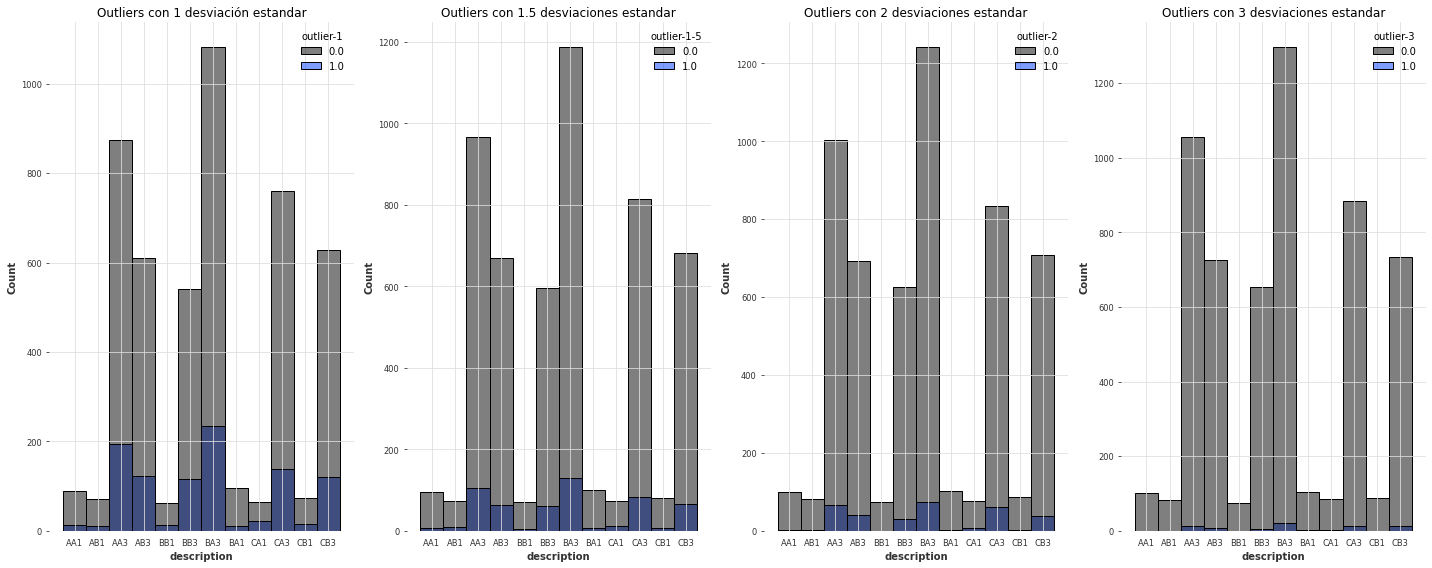

time: 1.17 s (started: 2022-03-06 00:34:07 -03:00)


In [23]:
# Graficamos el histograma de items con outliers
fig, ax = plt.subplots(1, 4,figsize=(20,8))
sns.histplot(data=df_clean, x='description', hue='outlier-1', ax=ax[0])
ax[0].set_title('Outliers con 1 desviación estandar')
sns.histplot(data=df_clean, x='description', hue='outlier-1-5', ax=ax[1])
ax[1].set_title('Outliers con 1.5 desviaciones estandar')
sns.histplot(data=df_clean, x='description', hue='outlier-2', ax=ax[2])
ax[2].set_title('Outliers con 2 desviaciones estandar')
sns.histplot(data=df_clean, x='description', hue='outlier-3', ax=ax[3])
ax[3].set_title('Outliers con 3 desviaciones estandar')
plt.tight_layout()

Usaremos entonces 2 desviaciones estandar desde la media para identificar outliers

In [24]:
# Vemos la distriución de datos sacados de la serie de kilos
df_clean['outlier-2'].value_counts()

0.0    5631
1.0     328
Name: outlier-2, dtype: int64

time: 0 ns (started: 2022-03-06 00:34:08 -03:00)


In [25]:
#Sacamos los outliers
df_clean_outliers = df_clean[df_clean['outlier-2'] == 0]

time: 0 ns (started: 2022-03-06 00:34:08 -03:00)


In [26]:
df_clean_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5631 entries, 0 to 5962
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   venta_neta     5631 non-null   float64       
 1   cod_cliente    5631 non-null   object        
 2   num_documento  5631 non-null   int64         
 3   cod_vendedor   5631 non-null   int64         
 4   description    5631 non-null   object        
 5   kilombos       5631 non-null   float64       
 6   grupo          5631 non-null   object        
 7   ds             5631 non-null   datetime64[ns]
 8   ds-monthYear   5631 non-null   object        
 9   ds-weekYear    5631 non-null   object        
 10  outlier-1      5631 non-null   float64       
 11  outlier-2      5631 non-null   float64       
 12  outlier-3      5631 non-null   float64       
 13  outlier-1-5    5631 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(5)
memory usage: 659.

Agrupación

In [27]:
# Transformamos las fechas de cada semana a pd.Int64Index
def convertWeeklyIndex(df):
    # Desde 2019-13 a 2021-48 hay 134 semanas
    año = 2019
    semana = 13
    index = 1
    indexes = []
    debugLabels = []
    while True:
        cero = '0' if semana < 10 else ''
        label = f'{año}-{cero}{semana}'
        if label in df.index:
            debugLabels.append(label)
            indexes.append(index)
        if label == '2021-48':
            break
        index += 1
        semana += 1
        if semana == 54:
            semana = 0
            año += 1
    # Creamos un nuevo DataFrame con las fechas de las semanas

    newIndex = pd.RangeIndex.from_range(indexes)
    intWeekly = df.copy()
    try :
        intWeekly.index = newIndex
    except:
        # Buscar el index en df que no esta en debugLabels
        notFound = list(filter(lambda x: x not in debugLabels, df.index))
        print(notFound)
    return intWeekly

# Transformamos las fechas de cada semana a pd.Int64Index
def convertMonthlyIndex(df):
    # Desde 2019-13 a 2021-48 hay 134 semanas
    año = 2019
    mes = 4
    index = 1
    indexes = []
    debugLabels = []
    while True:
        cero = '0' if mes < 10 else ''
        label = f'{año}-{cero}{mes}'
        if label in df.index:
            debugLabels.append(label)
            indexes.append(index)
        if label == '2021-12':
            break
        index += 1
        mes += 1
        if mes > 12:
            mes = 1
            año += 1
    # Creamos un nuevo DataFrame con las fechas de las semanas

    newIndex = pd.RangeIndex.from_range(indexes)
    intWeekly = df.copy()
    try :
        intWeekly.index = newIndex
    except:
        # Buscar el index en df que no esta en debugLabels
        notFound = list(filter(lambda x: x not in debugLabels, df.index))
        print(notFound)
    return intWeekly

time: 16 ms (started: 2022-03-06 00:34:09 -03:00)


In [28]:
def preprocessSeries(subDf, freq = 'D'):
    filler = MissingValuesFiller(fill=0.)
    #Instanciamos
    itemTimeSeries = TimeSeries.from_dataframe(subDf, None, value_cols=['kilombos_sum', 'kilombos_std', 'kilombos_max', 'kilombos_median'], freq=freq)
    # Completamos valores faltantes
    itemTimeSeries = filler.transform(itemTimeSeries)
    # Separamos los datos en train y test
    train, test = itemTimeSeries.split_before(0.8)
    # Separamos las covariantes
    scaled_train_covs = concatenate(
        [
            train['kilombos_max'],
            train['kilombos_std'],
            train['kilombos_median'],
        ],
        axis="component",
    )
    scaled_test_covs = concatenate(
        [
            test['kilombos_max'],
            test['kilombos_std'],
            test['kilombos_median'],
        ],
        axis="component",
    )
    return {
        'df': subDf,
        'series': itemTimeSeries,
        'train': {
            'target': train['kilombos_sum'],
            'past_covars': scaled_train_covs,
        },
        'test': {
            'target': test['kilombos_sum'],
            'past_covars': scaled_test_covs,
        }
    }

time: 0 ns (started: 2022-03-06 00:34:09 -03:00)


In [29]:
# Agrupamos según fecha y grupo
groupedDailyDf = df_clean_outliers.groupby(['ds', 'grupo']).agg({'kilombos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedDailyDf.columns = ['_'.join(col).strip() for col in groupedDailyDf.columns.values]
# Creamos un diccionario para guardar las series
series = {}
# Conseguimos según grupo
for itemCode in groupedDailyDf.index.get_level_values(1).unique():
    subDf = groupedDailyDf[groupedDailyDf.index.get_level_values(1) == itemCode].sort_values(by='ds')
    if(subDf.shape[0] > 1):
        subDf.index = subDf.index.droplevel(1)
        processed_series = preprocessSeries(subDf, freq='D')
        # Agregamos los datos al diccionario
        series[itemCode] = processed_series
# Conseguimos los totales
groupedTotalDailyDf = df_clean_outliers.groupby(['ds']).agg({'kilombos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedTotalDailyDf.columns = ['_'.join(col).strip() for col in groupedTotalDailyDf.columns.values]
series['total'] = preprocessSeries(groupedTotalDailyDf, freq='D')


time: 203 ms (started: 2022-03-06 00:34:09 -03:00)


In [30]:
# Agrupamos por semana y grupo
groupedWeeklyDf = df_clean_outliers.groupby(['ds-weekYear', 'grupo']).agg({'kilombos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedWeeklyDf.columns = ['_'.join(col).strip() for col in groupedWeeklyDf.columns.values]
# Iteramos por los grupos
weekly_series = {}
for itemCode in groupedWeeklyDf.index.get_level_values(1).unique():
    subDf = groupedWeeklyDf[groupedWeeklyDf.index.get_level_values(1) == itemCode].sort_values(by='ds-weekYear')
    if(subDf.shape[0] > 1):
        subDf.index = subDf.index.droplevel(1)
        # Convertimos los indices a pd.Int64Index
        subDf = convertWeeklyIndex(subDf)
        processed_series = preprocessSeries(subDf, freq='W')
        # Agregamos los datos al diccionario
        weekly_series[itemCode] = processed_series
# Agrupamos los totales semana
groupedTotalWeeklyDf = df_clean_outliers.groupby(['ds-weekYear']).agg({'kilombos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedTotalWeeklyDf.columns = ['_'.join(col).strip() for col in groupedTotalWeeklyDf.columns.values]
# Convertimos a pd.Int64Index
groupedTotalWeeklyDf = convertWeeklyIndex(groupedTotalWeeklyDf)
# Agregamos los datos al diccionario
weekly_series['total'] = preprocessSeries(groupedTotalWeeklyDf, freq='W')

TypeError: RangeIndex(...) must be called with object coercible to a range, [1, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144] was passed

time: 47 ms (started: 2022-03-06 00:34:09 -03:00)


In [ ]:
# Agrupamos según mes y gurpo
groupedMonthlyDf = df_clean_outliers.groupby(['ds-monthYear', 'grupo']).agg({'kilombos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedMonthlyDf.columns = ['_'.join(col).strip() for col in groupedMonthlyDf.columns.values]
monthly_series = {}
for itemCode in groupedMonthlyDf.index.get_level_values(1).unique():
    subDf = groupedMonthlyDf[groupedMonthlyDf.index.get_level_values(1) == itemCode].sort_values(by='ds-monthYear')
    if(subDf.shape[0] > 1):
        subDf.index = subDf.index.droplevel(1)
        # Convertimos los indices a pd.Int64Index
        subDf = convertMonthlyIndex(subDf)
        processed_series = preprocessSeries(subDf, freq='M')
        # Agregamos los datos al diccionario
        monthly_series[itemCode] = processed_series
# Agrupamos los totales semana
groupedTotalMonthlyDf = df_clean_outliers.groupby(['ds-monthYear']).agg({'kilombos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedTotalMonthlyDf.columns = ['_'.join(col).strip() for col in groupedTotalMonthlyDf.columns.values]
# Convertimos a pd.Int64Index
groupedTotalMonthlyDf = convertMonthlyIndex(groupedTotalMonthlyDf)
# Agregamos los datos al diccionario
monthly_series['total'] = preprocessSeries(groupedTotalMonthlyDf, freq='M')


Se quitaron las cancelaciones

Ahora se van a crear columnas para tener la fecha separada: separación por días, semanas y meses: revisar factibilidad y si es posible, agrupar en nuevos dataframe separados

In [ ]:
sales_AA = df_sales2[df_sales2.description.str.contains('AA', regex = True, na = False)]
sales_AB = df_sales2[df_sales2.description.str.contains('AB', regex = True, na = False)]
sales_BA = df_sales2[df_sales2.description.str.contains('BA', regex = True, na = False)]
sales_BB = df_sales2[df_sales2.description.str.contains('BB', regex = True, na = False)]
sales_CA = df_sales2[df_sales2.description.str.contains('CA', regex = True, na = False)]
sales_CB = df_sales2[df_sales2.description.str.contains('CB', regex = True, na = False)]

Agrupaciones temporales

Se generarán los conjuntos de datos considerando:
1. División temporal con totalidad de productos: agrupación diaria, semanal y mensual.
2. División temporal por producto: considerando los 6 tipos de producto, se realizarán las mismas agrupaciones temporales de 1.

Datos de temperatura y tiempo

Fuente: Dirección General de Aeronáutica Civil (DGAC), Dirección Meteorológica de Chile, Servicios Climáticos, temperatura media diaria en grados Celsius de Estación Quinta Normal (Región Metropolitana).

Diario: temperatura
Semanal y mensual: promedio de temperatura media de días correspondientes.

In [ ]:
df_temperature_week = pd.DataFrame(df_temperature.groupby([pd.Grouper(key = 'fecha', freq = 'W-MON', label = 'left')])['temperatura_media'].mean())
df_temperature_month = pd.DataFrame(df_temperature.groupby([pd.Grouper(key = 'fecha', freq = 'M', label = 'left')])['temperatura_media'].mean())

In [ ]:
#df_temperature_week y df_temperature_week ya tienen fecha como índice por la agrupación de la celda anterior

df_temperature.set_index('fecha', inplace = True)

## Exploratorio

### corregir describe

agregar agrupación por otro criterio? 
1. agrupar df diario por semana y mes: poner rangos por mes, mínimos y máximos

In [ ]:
df_list = [sales_AA, sales_AB, sales_BA, sales_BB, sales_CA, sales_CB]

for i in df_list:
  print(i.describe())

In [ ]:
df_days_list = [AA_day, AB_day, BA_day, BB_day, CA_day, CB_day]
df_weeks_list = [AA_week, AB_week, BA_week, BB_week, CA_week, CB_week]
df_months_list = [AA_month, AB_month, BA_month, BB_month, CA_month, CB_month]

In [ ]:
#gráficos de agrupaciones diarias

sns.set(font_scale = 0.7)
plt.rcParams["figure.dpi"] = 120 #DPI gráficos
plt.rcParams["figure.figsize"] = (20, 20)    

for n, i in enumerate(df_days_list):
    plt.subplot(6, 1, n+1)
    ax = sns.lineplot(data = i,
                      x = i.index, y = i['kilombos'])
    plt.title('Distribución diaria de {}'.format(n)) #CORREGIR
    plt.xlabel('Tiempo')
    plt.ylabel('Kilos vendidos')

In [ ]:
#gráficos de agrupaciones semanales

sns.set(font_scale = 0.7)
plt.rcParams["figure.dpi"] = 120 #DPI gráficos
plt.rcParams["figure.figsize"] = (20, 20)    

for n, i in enumerate(df_weeks_list):
    plt.subplot(6, 1, n+1)
    ax = sns.lineplot(data = i,
                      x = i.index, y = i['kilombos'])
    plt.title('Distribución diaria de {}'.format(n)) #CORREGIR
    plt.xlabel('Tiempo')
    plt.ylabel('Kilos vendidos')

In [ ]:
#gráficos de agrupaciones mensuales

sns.set(font_scale = 0.7)
plt.rcParams["figure.dpi"] = 120 #DPI gráficos
plt.rcParams["figure.figsize"] = (20, 20)    

for n, i in enumerate(df_months_list):
    plt.subplot(6, 1, n+1)
    ax = sns.lineplot(data = i,
                      x = i.index, y = i['kilombos'])
    plt.title('Distribución diaria de {}'.format(n)) #CORREGIR
    plt.xlabel('Tiempo')
    plt.ylabel('Kilos vendidos')

La cantidad de días con venta 0 es alta. Esto se debe a que la cantidad de ventas no es tal como para tener cada día compra de cada tipo de producto. Junto con ello, se tienen los días domingo en los cuales la empresa no factura.

In [ ]:
#Agrupación diaria
for i in df_days_list:
    print('Filas sin venta: ', i[i['kilombos'] == 0].shape[0], '| Filas totales: ', i.shape[0], '| Porcentaje de filas sin venta: ', round((i[i['kilombos'] == 0].shape[0]/i.shape[0])*100, 1), '%')

In [ ]:
#Agrupación semanal
for i in df_weeks_list:
    print('Filas sin venta: ', i[i['kilombos'] == 0].shape[0], '| Filas totales: ', i.shape[0], '| Porcentaje de filas sin venta: ', round((i[i['kilombos'] == 0].shape[0]/i.shape[0])*100, 1), '%')

In [ ]:
#Agrupación mensual
for i in df_months_list:
    print('Filas sin venta: ', i[i['kilombos'] == 0].shape[0], '| Filas totales: ', i.shape[0], '| Porcentaje de filas sin venta: ', round((i[i['kilombos'] == 0].shape[0]/i.shape[0])*100, 1), '%')

La grupación semanal tiene una cantidad de periodos sin venta proporcionalmente mucho menor a los conjuntos de datos diarios, y se acerca al objetivo del cliente: estimar mensualmente el stock de los productos. Por lo anterior, se continuará trabajando con esta temporalidad.

In [ ]:
sns.set(font_scale = 0.6)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (10, 5)

for n, i in enumerate(df_weeks_list):
    plt.subplot(1, 6, n+1)
    ax = sns.violinplot(data = i, y = i['kilombos'])
    plt.ylim(0, 300)
    plt.ylabel('Kilos vendidos')

Respecto a la dsitribución de los datos:

- Los productos A y B de primer tipo (productos 1 y 3) tienen mayor dispersión de venta. Son además los productos con menor cantidad de periodos sin venta, según las cifras anteriores.
- Los productos C de ambos tipos son los que tienen, en conjunto, una mayor concentración en valores bajos. Son también los que presentan mayor cantidad de periodos con venta 0.
- A pesar de la dispersión, el tercer cuartil solo supera los 100 kilos de venta semanal en el producto 3, mostrando una concentración de ventas de esta magnitud, o menor.
- Se observa que los productos 2, 4 y 6 (tipo B) tienden a tener ventas de menor volumen.

In [ ]:
from scipy.stats import skew, kurtosis

print('Análisis de conjuntos de datos semanales:\n')
print('Conjunto de datos AA_week, coeficiente de asimetría: ', round(skew(AA_week['kilombos']), 2), '| Curtosis: ', round(kurtosis(AA_week['kilombos']), 2))
print('Conjunto de datos AB_week, coeficiente de asimetría: ', round(skew(AB_week['kilombos']), 2), '| Curtosis: ', round(kurtosis(AB_week['kilombos']), 2))
print('Conjunto de datos BA_week, coeficiente de asimetría: ', round(skew(BA_week['kilombos']), 2), '| Curtosis: ', round(kurtosis(BA_week['kilombos']), 2))
print('Conjunto de datos BB_week, coeficiente de asimetría: ', round(skew(BB_week['kilombos']), 2), '| Curtosis: ', round(kurtosis(BB_week['kilombos']), 2))
print('Conjunto de datos CA_week, coeficiente de asimetría: ', round(skew(CA_week['kilombos']), 2), '| Curtosis: ', round(kurtosis(CA_week['kilombos']), 2))
print('Conjunto de datos CB_week, coeficiente de asimetría: ', round(skew(CB_week['kilombos']), 2), '| Curtosis: ', round(kurtosis(CB_week['kilombos']), 2))

Respecto al coeficiente de asimetría y curtosis (Fischer) para los conjuntos semanales, se tiene:
- Todos los coeficientes de asimetría son mayores a 0: la distribución de valores se concentra en ventas mayores al promedio.
- Los productos con distribuciones con mayor asimetría son los productos 1 y 4.
- Las ventas con un comportamiento más cercano al de una distribución normal son las de los productos 5 y 6 (?)
- Respecto a la curtosis, el producto 3 es el cual tiene montos de venta con que se acercan a una distribución mesocúrtica.
- En el caso de los productos 1, 2 y 4 se presentan distribuciones leptocúrticas, con mayor cantidad de ventas semanales en torno a la media.
- Los últimos dos productos presentan distribuciones platicúrticas, con curvas más achatadas y distribuciones más disperas.

?? punto 1 (al revés?)

## Análisis relacionados con series de tiempo

Importación de librerías para gráficos ACF Y PACF

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (20, 12))
for i, ts in enumerate([series['total']['df']['kilombos_sum'], weekly_series['total']['df']['kilombos_sum'], monthly_series['total']['df']['kilombos_sum']]):
    plot_acf(ts, ax=ax[i][0])
    plot_pacf(ts, ax=ax[i][1], lags=15)
ax[0][0].set_title('Auto-correlación diaria')
ax[0][1].set_title('Auto-correlación parcial diaria')
ax[1][0].set_title('Auto-correlación semanal')
ax[1][1].set_title('Auto-correlación parcial semanal')
ax[2][0].set_title('Auto-correlación mensual')
ax[2][1].set_title('Auto-correlación parcial mensual');

In [ ]:
sns.set(font_scale = 1.1)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (10,6)

AA_acf = plot_acf(AA_week.kilombos, lags = 100)
plt.title("Conjunto de datos AA_weeks: Gráfico de autocorrelación con lags = 100")

In [ ]:
sns.set(font_scale = 1.1)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (10, 6)

AA_acf = plot_pacf(AA_week.kilombos)
plt.title("Conjunto de datos AA_weeks: Gráfico de autocorrelación parcial")

Considerando como ejemplo el primer conjunto de datos con temporalidad semanal, se observan lags con grados de autorrelación parcial significativos, fuera de la banda mostrada. Se destacan los lags 1, 2, 3, 4 y 6 (semanas).

Guardar lags = 1, 2, 3, 4, 5, 7

In [ ]:
sns.set(font_scale = 1.1)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (10, 6)

AA_acf = plot_pacf(CB_week.kilombos)
plt.title("Conjunto de datos CB_weeks: Gráfico de autocorrelación parcial")

Al repetir el ejercicio con el producto 6, los lags significativos se repiten, y se suma otro de 19 semanas.

gráficos df.rolling?

In [ ]:
plt.plot(AA_week.kilombos.rolling(window = '7D').mean()) #opcional

In [ ]:
plt.plot(AA_week.kilombos.rolling(window = '7D').std()) #falla el output

## Seasonal decomposition

In [ ]:
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode

In [ ]:
weekly_series['total']['series']['kilombos_sum']

In [ ]:
trend, season = extract_trend_and_seasonality(weekly_series['total']['series']['kilombos_sum'], freq=52, model=ModelMode.ADDITIVE)
fig, ax = plt.subplots(2, 1, figsize = (15, 10), sharex=True)
trend.plot(ax=ax[0])
ax[0].set_title('Tendencia')
season.plot(ax=ax[1])
ax[1].set_title('Estacionalidad')
ax[1].set_xticklabels(['2019-13', '2021-48'])
fig.autofmt_xdate()
plt.tight_layout();

In [ ]:
sns.set(font_scale = 0.7)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (10, 6)

fig = decomposition.plot()

fig.suptitle('Descomposión de la serie de tiempo de AA_week')
plt.show()

Al realizar una descomposición de la serie de tiempo del producto 1 (temporalidad semanal), es posible ver la tendencia creciente de ventas en el periodo. Para continuar con el análisis, se elegirá uno de los lags ya visualizados en el gráfico de PACF para que esa serie sea el nuevo conjunto de datos. Se revisará cada producto para realizar la misma tarea.

In [ ]:
# lag = 1W, 2W, 3W, 4W, 5W y 6W

AA_week['lag_1W'] = AA_week['kilombos'] - AA_week['kilombos'].shift(1)
AA_week['lag_2W'] = AA_week['kilombos'] - AA_week['kilombos'].shift(2)
AA_week['lag_3W'] = AA_week['kilombos'] - AA_week['kilombos'].shift(3)
AA_week['lag_4W'] = AA_week['kilombos'] - AA_week['kilombos'].shift(4)
AA_week['lag_6W'] = AA_week['kilombos'] - AA_week['kilombos'].shift(6)

sns.set(font_scale = 0.8)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (8, 5)
plt.plot(AA_week.lag_1W)
plt.title('Lag = 1 semana')
plt.ylabel('Diferencia en kilos vendidos')

En este caso, al graficar la serie con lag de 1 semana, se observa que la curva ya no presenta la tendencia mostrada en la descomposición, por lo que esta serie será utilizada de aquí en adelante para la modelación. Sobre esta serie se chequea stationarity con el Augmented Dickey-Fuller Test.

In [ ]:
def adf_test(series):
  result = adfuller(series)
  print(f'ADF Statistic: {result[0]}', '\n', f'p-value: {result[1]}')

In [ ]:
adf_test(AA_week.iloc[1:, 2])

Es una serie estacionaria, con un intervalo de confianza de un 95%.

## Modelos

1. Exponential Smoothing

- Para datos con 1 variable
- Utiliza una ponderación tal que las observaciones más alejadas (en el tiempo) tienen un peso menor, dando espacio a las más recientes.
- Existe el Single Exponential Smoothing: datos sin tendencia, Double Exponential Smootinh: con tendencia y Triple Exponential Smoothing: incluye seasonality :D

Trend y Seasonality pueden ser ajustados de forma lineal y exponencial.

!! {información global, Darts solo tiene un tipo de modelo, que según los parámetros que muestra, parece ser del primer tipo: no hay hiperparámetros a ajustar que sugieran las otras modalidades}

2. Kalman Forecaster

Modelo predictivo que tiene filtro intermedio: usa una nueva serie de tiempo sin ruido, eliminado a través del método Kalman. Usado ampliamente en el área robótica y física, no encontré fuentes actualizadas que lo aplicaran para forecasting de ventas.

### ARIMA

In [ ]:
# Creamos una instancia de ARIMA
arima_model = ARIMA(p=9, d=1, q=4, seasonal_order=(1, 1, 1, 52))
train = weekly_series['total']['train']['target']
test = weekly_series['total']['test']['target']
# Ajustamos el modelo
arima_model.fit(train['kilombos_sum'])
# Predecimos
predictions = arima_model.predict(len(test))
# Conseguimos las metricas de error
prediction_mae = mae(test, predictions)
prediction_mape = mape(test, predictions)

In [ ]:
# Graficamos
plt.figure(figsize=(20, 8))
train.plot(label='Entrenamiento')
test.plot(label='Validación')
predictions.plot(label='Predicciones')
plt.suptitle('Predicciones ARIMA')
plt.title('MAE: ' + str(round(prediction_mae, 2)) + ' | MAPE: ' + str(round(prediction_mape, 2)));


In [ ]:
print('MAE', mae(test, predictions))
print('MAPE', mape(test, predictions))

In [ ]:
ma

Exponential Smoothing

In [ ]:
AA_week_model1_data = AA_week.drop(columns = ['kilombos', 'temperatura_media', 'lag_2W', 'lag_3W', 'lag_4W', 'lag_5W', 'lag_6W']) #se deja lag_1W
AA_week_model1_data = AA_week_model1_data[1:]

AA_week_train, AA_week_test = AA_week_model1_data[AA_week_model1_data.index <= '2021-10-31'], AA_week_model1_data[AA_week_model1_data.index > '2021-10-31']
print(f'Cantidad de filas de dataframe original AA_week: {AA_week_model1_data.shape[0]}',
      f'\nCantidad de filas de conjunto de entrenamiento: {AA_week_train.shape[0]}',
      f'\nCantidad de filas de conjunto de validación: {AA_week_test.shape[0]}')

In [ ]:
AA_week_model1_data

In [ ]:
AA_week_model1 = ExponentialSmoothing()
AA_week_model1.fit(AA_week_train)
AA_week_model1_fc = AA_week_model1.predict(len(AA_week_test), num_samples = 500)

sns.set(font_scale = 0.7)
plt.rcParams["figure.dpi"] = 120 #DPI gráficos
plt.rcParams["figure.figsize"] = (20, 20)    

sns.lineplot(data = AA_week_model1_data, x = AA_week_model1_data.index, y = AA_week_model1_data['kilombos'], label = 'data')
sns.lineplot(data = AA_week_model1_fc, x = AA_week_model1_fc.index, y = AA_week_model1_fc['kilombos'], label = 'predicción')
plt.legend()
plt.show()

Cálculo de MAPE y rho_risk (métrica propia de modelos probabilísticos)

In [ ]:
print(f'MAPE de la predicción: {mape(AA_week_test, AA_week_model1_fc)}')

for rho in [0.05, 0.1, 0.5, 0.9, 0.95]:
  rr = rho_risk(A_week_test, AA_week_model1_fc, rho = rho)
  print(f'rho risk en cuartil {rho}: {rr}')

# EXTRAS

In [ ]:
AA_week_model1 = KalmanForecasting()
AA_week_model1.fit(AA_week_train)
AA_week_model1_fc = AA_week_model1.predict(len(AA_week_test), num_samples = 100)

sns.set(font_scale = 0.7)
plt.rcParams["figure.dpi"] = 120 #DPI gráficos
plt.rcParams["figure.figsize"] = (20, 20)    

sns.lineplot(data = AA_week_model1_data, x = AA_week_model1_data.index, y = AA_week_model1_data['kilombos'], label = 'data')
sns.lineplot(data = AA_week_model1_fc, x = AA_week_model1_fc.index, y = AA_week_model1_fc['kilombos'], label = 'predicción')
plt.legend()
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)

for n, i in enumerate(df_weeks_list):
    plt.subplot(6, 1, n+1)
    ax = sns.boxplot(data = i,
                     x = i['kilombos'])
    plt.title('Distribución diaria de {}'.format(n)) #CORREGIR
    plt.xlabel('Tiempo')
    plt.ylabel('Kilos vendidos')

In [ ]:
df_sales2['day'] = df_sales2['fecha'].dt.day
df_sales2['month'] = df_sales2['fecha'].dt.month
df_sales2['year'] = df_sales2['fecha'].dt.year

In [ ]:
#borrar?
df_sales_month = pd.DataFrame(df_sales2.groupby(['description', 'year', 'month']).sum())
df_sales_day = pd.DataFrame(df_sales2.groupby(['description', 'year', 'month', 'day']).sum())

In [ ]:
#no se ejecutó, no sirve

df_sales_cancelled_clients = df_sales_cancelled['cod_cliente']
df_sales_cancelled_dates = df_sales_cancelled['fecha']
df_sales_transaction_cancelled2 = df_sales.cod_cliente.isin(df_sales_cancelled_clients)
df_sales_transaction_cancelled2 = df_sales[df_sales_transaction_cancelled2]
df_sales_transaction_cancelled2 = df_sales_transaction_cancelled2.fecha.isin(df_sales_cancelled_dates)
df_sales_transaction_cancelled2 = df_sales_transaction_cancelled2[df_sales_transaction_cancelled2]

In [ ]:
sns.set(font_scale = 0.7) #escalar fuente para acomodar a gráfico
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (5, 5) #escalar gráficos
plt.rcParams["figure.dpi"] = 120 #DPI gráficos (también modifica tamaño)

ax = sns.countplot(x = df_all["pf_general"])
plt.title(f"Distribución de vector atributo Caso 1")

plt.tight_layout()

In [ ]:
ts = TimeSeries.from_dataframe(df_limpio, 'Fecha', 'Kilombos')
ts = fill_missing_values(ts, "auto")

train, val = ts.split_after(pd.Timestamp("20210906"))
train.plot(label="train")
val.plot(label="val")

In [ ]:
model = FFT(required_matches={'week'}, trend='exp', nr_freqs_to_keep=26)
model.fit(train)
pred_val = model.predict(len(val))

train.plot(label="train" )
val.plot(label="val")
pred_val.plot(label="predict")
print("MAPE:", mape(pred_val, val))

Fuentes:
    
1. https://towardsdatascience.com/violin-plots-explained-fb1d115e023d
2. https://machinelearningmastery.com/white-noise-time-series-python/#:~:text=A%20time%20series%20may%20be,other%20values%20in%20the%20series.
3. https://medium.com/data-science-in-your-pocket/preprocessing-for-time-series-forecasting-3a331dbfb9c2
4. https://towardsdatascience.com/violin-plots-explained-fb1d115e023d
5.http://recursostic.educacion.es/descartes/web/materiales_didacticos/unidimensional_lbarrios/asimetria_est.htm
6. 